# Описание проекта

**Цель:** Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Задачи:**

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# Описание данных

**Данные находятся в трёх файлах:**

/datasets/gold_recovery_train.csv — обучающая выборка 

/datasets/gold_recovery_test.csv — тестовая выборка 

/datasets/gold_recovery_full.csv — исходные данные 

Данные делятся на следующие типы: 

- Технологический процессы

- Параметры этапов

- Наименование признаков

Наименование признаков должно быть такое: [этап].[тип_параметра].[название_параметра]

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

# Структура проекта

## Шаг 1. Подготовка данных

1.1. Откройте файлы и изучите их.

1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

1.4. Проведите предобработку данных.

## Шаг 2. Анализ данных

2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

## Шаг 3. Модель 

3.1. Напишите функцию для вычисления итоговой sMAPE.

3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

## Шаг 3. Результаты исследования

Написать выводы и рекомендации по проекту.

# 1. Подготовка данных

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,8) 
plt.style.use('ggplot') 
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

Загрузим данные:

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date')

In [3]:
test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col='date')

In [4]:
full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col='date')

### Изучим датасет train:

In [5]:
train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,"1,549.78",-498.91,"1,551.43",-516.40,"1,549.87",-498.67,"1,554.37",-493.43,"41,885.71","3,481.78","3,520.34",2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,"1,603.01",-434.72,"1,602.38",-442.20,"1,598.94",-451.29,"1,404.47",-455.46,"1,416.35",-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,"1,576.17",-500.90,"1,575.95",-499.87,"1,575.99",-499.32,"1,574.48",-498.93,"42,050.86","3,498.37","3,489.98",2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,"1,000.29",-400.0

In [6]:
train.tail()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-08-18 06:59:59,3.22,11.36,6.80,46.71,73.76,8.77,3.14,10.40,1.53,123.38,8.03,6.50,1.30,6.56,12.45,7.06,32.94,22.85,6.53,3.93,2.31,"1,648.42",-400.38,"1,648.74",-400.36,"1,648.58",-399.36,"1,648.83",-399.67,"45,912.94","2,497.65","2,499.18",1.16,6.09,4.62,560.89,85.72,37.37,5.34,7.76,9.16,7.77,9.16,11.12,10.98,30.07,18.60,89.57,4.21,0.61,16.67,0.75,"1,199.25",-300.85,"1,149.81",-498.79,"1,047.96",-498.41,946.64,-499.15,849.66,-499.21,849.76,-497.45,0.00,0.00,0.00,0.00,35.04,-499.05,29.91,-499.98,26.00,-499.95,22.99,-499.97,23.03,-501.17,20.01,-499.74,18.01,-499.83,13.00,-500.16,20.01,-501.30
2018-08-18 07:59:59,3.20,11.35,6.86,46.87,69.05,8.90,3.13,10.55,1.61,120.88,7.96,6.50,1.30,6.61,12.62,7.54,32.93,23.00,6.63,4.09,2.46,"1,649.82",-399.93,"1,649.36",-399.72,"1,648.66",-401.20,"1,649.73",-400.64,"46,200.10","2,614.40","2,518.55",1.17,6.12,4.14,559.03,119.50,38.59,4.84,7.36,9.30,7.10,9.30,11.43,10.89,29.78,18.44,87.72,4.18,0.65,16.96,0.77,"1,196.57",-299.51,"1,147.68"

In [7]:
train.sample(5)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-25 18:00:00,3.83,13.54,10.05,45.27,55.57,11.72,3.24,17.55,4.05,218.74,16.01,7.25,1.10,9.26,12.24,18.38,32.93,15.88,4.16,10.61,2.89,"1,549.05",-500.09,"1,553.17",-499.53,"1,502.13",-500.04,"1,499.39",-500.03,"45,144.81","2,401.13","2,409.38",2.04,8.30,4.03,630.31,64.14,40.30,8.20,13.11,7.40,13.12,7.40,10.97,9.34,29.38,19.58,83.68,5.13,0.85,18.63,2.06,"1,000.15",-599.61,"1,548.68",-499.79,"1,499.80",-499.10,"1,398.17",-500.47,"1,298.87",-500.54,"1,299.35",-499.95,14.45,6.86,14.41,4.59,25.03,-499.39,22.94,-499.74,24.00,-500.43,22.96,-500.80,15.01,-554.87,13.10,-557.05,10.04,-602.86,8.09,-599.04,11.98,-601.06
2017-07-07 17:59:59,5.22,9.72,11.00,44.76,69.15,6.58,2.48,10.37,2.43,122.77,5.99,7.16,0.81,8.78,10.13,8.58,32.33,12.07,1.31,6.92,2.83,"1,690.76",-499.84,"1,668.86",-499.46,"1,700.83",-499.52,"1,699.54",-498.87,"46,981.48","5,592.28","5,592.53",2.29,6.88,3.06,321.38,51.94,31.82,7.01,17.00,6.00,17.00,6.00,10.39,7.70,32.24,21.55,88.27,4.44,0.49,16.78,1.15,"1,000.14"

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_cleaner.i

In [9]:
train.duplicated().sum()

16

In [10]:
train.drop_duplicates().reset_index(drop=True)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,"1,549.78",-498.91,"1,551.43",-516.40,"1,549.87",-498.67,"1,554.37",-493.43,"41,885.71","3,481.78","3,520.34",2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,"1,603.01",-434.72,"1,602.38",-442.20,"1,598.94",-451.29,"1,404.47",-455.46,"1,416.35",-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,"1,576.17",-500.90,"1,575.95",-499.87,"1,575.99",-499.32,"1,574.48",-498.93,"42,050.86","3,498.37","3,489.98",2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,"1,000.29",-400.07,"1,600.75",-449.95,"1,600.48",-449.83,"1,600.53",-449.95,"1,399.23",-450.87,"1,399.72",-450.12,14.27,4.59,9.00,2.49,25.88,-49

In [11]:
train.isnull().sum()

final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 86, dtype: int64

In [12]:
train.duplicated().sum()

16

### Изучим датасет test:

In [13]:
test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.80,14.99,8.08,1.01,"1,398.98",-500.23,"1,399.14",-499.92,"1,400.10",-500.70,"1,399.00",-499.49,13.13,5.64,489.79,62.71,42.02,12.08,16.92,6.15,16.87,6.15,"1,001.85",-350.30,"1,249.74",-399.11,"1,249.75",-399.40,"1,198.29",-399.49,999.47,-399.53,949.57,-398.18,24.94,-500.49,14.95,-500.01,20.02,-450.40,13.99,-449.83,12.02,-497.80,8.02,-501.29,7.95,-432.32,4.87,-500.04,26.71,-499.71
2016-09-01 01:59:59,215.39,14.99,8.08,0.99,"1,398.78",-500.06,"1,398.06",-499.78,"1,396.15",-499.24,"1,399.51",-500.42,13.04,5.53,490.10,61.96,41.19,11.92,17.00,6.00,17.00,6.00,998.69,-350.43,"1,248.40",-399.95,"1,249.51",-399.63,"1,200.51",-399.94,"1,000.00",-399.49,950.20,-405.79,24.92,-499.81,14.93,-500.76,19.99,-450.11,14.09,-450.06,12.06,-498.70,8.13,-499.63,7.96,-525.84,4.88,-500.16,25.02,-499.82
2016-09-01 02:59:59,215.26,12.88,7.79,1.00,"1,398.49",-500.87,"1,398.86",-499.76,"1,398.08",-502.15,"1,399.50",-499.72,13.14,5.43,489.62,66.90,42.55,12.09,16.99,5.85,16.98,5.85,998.52,-349.78,"1,247.44",-400.26,"1,248.21",-401.07,"1,199.77",-400.79,999.93,-399.24,950.32,-400.86,24.91,-500.30,15.00,-500.99,20.04,-450.26,14.08,-449.66,11.96,-498.77,8.10,-500.83,8.07,-500.80,4.91,-499.83,24.99,-500.62
2016-09-01 03:59:59,215.34,12.01,7.64,0.86,"1,399.62",-498.86,"1,397.44",-499.21,"1,400.13",-498.36,"1,401.07",-501.04,12.40,5.11,476.62,59.87,41.06,12.18,16.53,5.80,16.52,5.80,"1,000.28",-350.17,"1,251.32",-398.66,"1,250.49",-399.75,"1,199.40",-397.50,"1,001.93",-400.44,950.74,-399.80,24.89,-499.38,14.92,-499.86,20.03,-449.37,14.01,-449.53,12.03,-498.35,8.07,-499.47,7.90,-500.87,4.93,-499.96,24.95,-498.71
2016-09-01 04:59:59,199.10,10.68,7.53,0.81,"1,401.27",-500.81,"1,398.13",-499.50,"1,402.17",-500.81,"1,399.48",-499.37,11.33,4.77,488.25,63.32,41.27,11.29,13.61,5.74,13.65,5.74,996.54,-350.56,"1,304.66",-399.51,"1,306.46",-399.05,"1,248.70",-400.88,"1,058.84",-398.99,949.65,-399.28,24.89,-499.36,14.98,-500.19,19.96,-450.64,14.01,-450.02,12.03,-500.79,8.05,-500.40,8.11,-509.53,4.96,-500.36,25.00,-500.86


In [14]:
test.tail()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-31 19:59:59,173.96,15.96,8.07,0.90,"1,401.93",-499.73,"1,401.44",-499.19,"1,399.81",-499.60,"1,400.33",-499.24,11.64,4.70,521.69,66.76,42.02,10.55,10.11,7.20,10.11,7.20,"1,399.94",-300.00,"1,049.64",-500.07,951.92,-499.65,852.34,-498.46,851.44,-500.29,851.46,-499.74,21.91,-499.92,19.91,-499.73,24.94,-500.10,12.97,-499.95,14.00,-500.16,12.07,-499.67,7.98,-499.52,5.93,-499.97,8.99,-499.76
2017-12-31 20:59:59,172.91,16.00,8.07,0.90,"1,447.08",-494.72,"1,448.85",-465.96,"1,443.89",-503.59,"1,447.65",-480.40,11.34,4.48,530.20,62.56,41.10,10.25,9.98,7.20,9.98,7.20,"1,406.12",-299.06,"1,055.72",-498.25,956.85,-497.40,855.39,-495.70,852.07,-499.44,851.33,-496.58,25.32,-497.03,23.31,-498.89,26.37,-499.22,17.70,-499.55,16.75,-496.03,13.37,-499.12,9.29,-496.89,7.37,-499.94,8.99,-499.90
2017-12-31 21:59:59,171.14,15.99,8.07,1.17,"1,498.84",-501.77,"1,499.57",-495.52,"1,502.75",-520.67,"1,502.59",-498.26,11.29,4.41,546.31,73.65,41.10,10.17,10.18,7.20,10.19,7.20,"1,396.20",-300.21,"1,047.88",-499.60,948.96,-499.55,856.33,-500.10,850.61,-499.47,850.28,-498.51,29.08,-500.53,26.89,-500.98,28.00,-500.57,23.00,-500.48,19.99,-499.79,15.10,-499.94,10.99,-498.35,9.02,-500.04,8.98,-497.79
2017-12-31 22:59:59,179.70,15.44,8.07,1.50,"1,498.47",-500.48,"1,497.99",-519.20,"1,496.57",-487.48,"1,502.69",-501.57,11.29,4.34,547.33,78.07,41.72,10.07,10.73,7.20,10.73,7.20,"1,403.94",-300.03,"1,049.80",-499.80,950.77,-500.37,847.65,-499.92,849.41,-500.38,850.08,-500.48,29.10,-499.69,27.05,-499.86,27.98,-499.91,23.05,-499.74,19.96,-499.96,15.03,-499.72,11.01,-499.99,9.01,-499.94,9.01,-500.15
2017-12-31 23:59:59,181.56,15.00,8.07,1.62,"1,498.10",-499.80,"1,501.74",-505.15,"1,499.54",-492.43,"1,499.67",-499.77,10.90,4.09,564.54,77.68,40.89,9.70,10.79,7.20,10.79,7.20,"1,400.61",-299.99,"1,052.78",-499.76,950.79,-499.36,850.64,-500.43,850.37,-500.82,850.68,-498.54,29.10,-500.43,26.89,-500.09,28.02,-500.17,23.01,-500.22,20.03,-500.73,14.91,-499.95,10.99,-500.66,8.99,-500.34,8.99,-500.76


In [15]:
test.sample(5)


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-23 22:59:59,206.66,8.52,7.40,1.35,"1,448.10",-496.33,"1,454.60",-504.25,"1,453.05",-501.80,"1,449.28",-500.85,6.06,4.03,592.34,69.96,42.68,8.21,17.00,6.70,17.00,6.70,"1,004.44",-300.00,"1,304.82",-499.84,"1,252.43",-500.11,"1,201.55",-500.07,"1,001.37",-499.67,"1,000.01",-500.84,26.05,-499.74,21.07,-499.73,22.99,-500.05,15.04,-500.13,15.00,-498.45,12.96,-405.47,10.93,-499.66,8.98,-499.75,12.01,-499.76
2016-09-07 14:59:59,167.88,10.07,8.24,0.70,"1,296.68",-498.47,"1,303.63",-499.77,"1,301.49",-499.39,"1,303.69",-501.86,10.53,3.45,401.19,42.17,32.78,10.02,14.00,5.60,13.99,5.60,"1,000.22",-499.91,"1,250.47",-499.77,"1,256.08",-499.54,"1,199.11",-494.04,"1,004.01",-499.17,952.20,-505.78,21.95,-499.91,11.98,-499.65,11.95,-499.99,7.97,-599.64,8.01,-500.45,5.01,-603.07,7.92,-600.54,3.07,-598.64,20.01,-597.05
2016-09-23 15:59:59,0.85,nan,7.68,0.01,0.00,-799.00,0.00,-799.99,0.00,-799.94,0.00,-799.79,0.00,0.00,0.22,48.03,0.00,0.00,nan,0.01,nan,nan,-0.00,-650.04,-0.61,-650.09,-0.00,-644.52,-0.98,-629.72,-1.93,-650.13,-2.35,-649.85,0.09,-799.49,0.00,-794.50,0.00,-799.55,0.00,-720.21,0.00,-744.83,0.00,-799.79,-0.17,-797.64,0.74,-800.01,0.21,-799.88
2017-10-29 02:59:59,122.42,8.46,6.04,1.80,"1,600.33",-500.88,"1,598.04",-584.72,"1,599.52",-501.12,"1,598.47",-499.07,10.02,3.05,516.08,49.63,37.27,8.24,17.00,6.00,17.00,6.00,"1,295.32",-299.86,"1,147.33",-500.28,"1,099.89",-500.26,996.81,-500.80,949.25,-501.21,949.70,-499.87,29.09,-499.94,25.86,-500.08,24.98,-499.89,23.00,-500.07,18.02,-499.63,16.08,-500.05,14.91,-499.46,11.00,-500.05,16.00,-499.86
2016-11-18 22:59:59,235.33,7.97,7.63,1.59,"1,594.32",-500.33,"1,595.70",-500.40,"1,597.63",-501.74,"1,598.73",-499.32,10.07,3.52,492.61,46.92,35.94,10.67,14.00,6.40,14.00,6.40,999.96,-500.35,"1,499.92",-400.03,"1,499.74",-400.52,"1,399.31",-400.51,"1,199.74",-402.65,"1,100.10",-400.93,25.06,-500.29,22.04,-499.79,30.05,-499.84,27.01,-499.81,16.03,-493.98,13.93,-368.54,15.84,-498.63,14.03,-500.15,22.01,-499.69


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                         584

In [17]:
test.duplicated().sum()

6

In [18]:
test.isnull().sum()

primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257
rougher.input.floatbank10_xanthate            123


In [19]:
test.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

Изучим датасет full:

In [20]:
full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,"1,549.78",-498.91,"1,551.43",-516.40,"1,549.87",-498.67,"1,554.37",-493.43,"41,885.71","3,481.78","3,520.34",2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,"1,603.01",-434.72,"1,602.38",-442.20,"1,598.94",-451.29,"1,404.47",-455.46,"1,416.35",-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,"1,576.17",-500.90,"1,575.95",-499.87,"1,575.99",-499.32,"1,574.48",-498.93,"42,050.86","3,498.37","3,489.98",2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,"1,000.29",-400.0

In [21]:
full.tail()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-08-18 06:59:59,3.22,11.36,6.80,46.71,73.76,8.77,3.14,10.40,1.53,123.38,8.03,6.50,1.30,6.56,12.45,7.06,32.94,22.85,6.53,3.93,2.31,"1,648.42",-400.38,"1,648.74",-400.36,"1,648.58",-399.36,"1,648.83",-399.67,"45,912.94","2,497.65","2,499.18",1.16,6.09,4.62,560.89,85.72,37.37,5.34,7.76,9.16,7.77,9.16,11.12,10.98,30.07,18.60,89.57,4.21,0.61,16.67,0.75,"1,199.25",-300.85,"1,149.81",-498.79,"1,047.96",-498.41,946.64,-499.15,849.66,-499.21,849.76,-497.45,0.00,0.00,0.00,0.00,35.04,-499.05,29.91,-499.98,26.00,-499.95,22.99,-499.97,23.03,-501.17,20.01,-499.74,18.01,-499.83,13.00,-500.16,20.01,-501.30
2018-08-18 07:59:59,3.20,11.35,6.86,46.87,69.05,8.90,3.13,10.55,1.61,120.88,7.96,6.50,1.30,6.61,12.62,7.54,32.93,23.00,6.63,4.09,2.46,"1,649.82",-399.93,"1,649.36",-399.72,"1,648.66",-401.20,"1,649.73",-400.64,"46,200.10","2,614.40","2,518.55",1.17,6.12,4.14,559.03,119.50,38.59,4.84,7.36,9.30,7.10,9.30,11.43,10.89,29.78,18.44,87.72,4.18,0.65,16.96,0.77,"1,196.57",-299.51,"1,147.68"

In [22]:
full.sample()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-02-26 15:00:00,5.21,12.37,13.03,40.93,73.51,12.94,2.60,11.73,3.04,148.76,12.24,8.42,0.66,10.60,10.55,18.16,31.39,16.00,3.52,8.85,3.28,"1,596.06",-450.01,"1,600.24",-449.77,"1,598.84",-450.88,"1,049.48",-349.62,"48,488.65","3,153.83","3,146.60",2.07,11.68,4.61,350.93,41.18,31.24,9.52,10.45,5.77,10.47,5.76,12.88,8.98,29.64,20.09,92.23,5.16,0.27,12.75,1.31,"1,099.09",-500.74,"1,648.15",-499.78,"1,648.40",-499.95,"1,635.79",-499.51,"1,599.98",-500.66,"1,599.64",-500.83,14.15,5.46,11.47,3.50,27.97,-499.68,26.02,-500.04,26.03,-499.48,23.96,-500.05,14.04,-499.57,13.98,-500.21,11.98,-501.01,9.99,-500.23,20.02,-500.25


In [23]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_cleaner.i

In [24]:
full.duplicated().sum()

22

In [25]:
full.drop_duplicates().reset_index(drop=True)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,"1,549.78",-498.91,"1,551.43",-516.40,"1,549.87",-498.67,"1,554.37",-493.43,"41,885.71","3,481.78","3,520.34",2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,"1,603.01",-434.72,"1,602.38",-442.20,"1,598.94",-451.29,"1,404.47",-455.46,"1,416.35",-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,"1,576.17",-500.90,"1,575.95",-499.87,"1,575.99",-499.32,"1,574.48",-498.93,"42,050.86","3,498.37","3,489.98",2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,"1,000.29",-400.07,"1,600.75",-449.95,"1,600.48",-449.83,"1,600.53",-449.95,"1,399.23",-450.87,"1,399.72",-450.12,14.27,4.59,9.00,2.49,25.88,-49

In [26]:
full.duplicated().sum()

22

In [27]:
full.isnull().sum()

final.output.concentrate_ag                     89
final.output.concentrate_pb                     87
final.output.concentrate_sol                   385
final.output.concentrate_au                     86
final.output.recovery                         1963
                                              ... 
secondary_cleaner.state.floatbank5_a_level     101
secondary_cleaner.state.floatbank5_b_air       101
secondary_cleaner.state.floatbank5_b_level     100
secondary_cleaner.state.floatbank6_a_air       119
secondary_cleaner.state.floatbank6_a_level     101
Length: 86, dtype: int64

Эффективность обогащения:

C — доля золота в концентрате после флотации/очистки;

F — доля золота в сырье/концентрате до флотации/очистки;

T — доля золота в отвальных хвостах после флотации/очистки.

In [28]:
t = train['rougher.output.tail_au']
f = train['rougher.input.feed_au']
c = train['rougher.output.concentrate_au']
def recovery(c, f, t):
    numerator = (c*(f-t))
    denominator =(f*(c-t))
    rec = numerator / denominator * 100
    rec[rec<0] = np.nan
    rec[rec>100] = np.nan
    return rec
rec = recovery(c, f, t)
print(rec.mean())

82.39420120842001


Посчитаем среднеквадратическую ошибку:

In [29]:
train['MAE'] = abs(train['rougher.output.recovery'] - rec)
train['MAE'].mean()

9.444891926100695e-15

Заполним пропуски:

In [30]:
import numpy as np

#чистим данные от наблюдений с отсутствующими целевыми переменными
#и импутируем пропуски в показателях предыдущими значениями
def clean_dataset(dataset):
    dataset['rougher.output.recovery'].replace('', np.nan, inplace=True)
    dataset.dropna(subset=['rougher.output.recovery'], inplace=True)
    dataset['final.output.recovery'].replace('', np.nan, inplace=True)
    dataset.dropna(subset=['final.output.recovery'], inplace=True)
    
    print('null rougher count', dataset['rougher.output.recovery'].isnull().sum())
    print('null final count', dataset['final.output.recovery'].isnull().sum())
    
    dataset.ffill(axis = 0, inplace=True)
    
clean_dataset(train)

test = test.join(full[['rougher.output.recovery','final.output.recovery']])
clean_dataset(test)

clean_dataset(full)

null rougher count 0
null final count 0
null rougher count 0
null final count 0
null rougher count 0
null final count 0


In [31]:
pd.set_option('display.max_columns', None)
print(test.columns)

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

In [32]:
print(full.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

Пропущенные значения:

'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au','primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au','rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.output.recovery',
       'rougher.output.tail_ag', 'rougher.output.tail_pb',
       'rougher.output.tail_sol', 'rougher.output.tail_au','rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.input.feed_ag','secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb',
       'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au'

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 87 columns):
final.output.concentrate_ag                           14149 non-null float64
final.output.concentrate_pb                           14149 non-null float64
final.output.concentrate_sol                          14149 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14149 non-null float64
final.output.tail_sol                                 14149 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14149 non-null float64
primary_cleaner.input.depressant                      14149 non-null float64
primary_cleaner.i

Вывод: 

1. recovery равен 82%, что доказывает эффективность обогащения

2. среднеквадратичная ошибка - очень маленькое чило

3. В тестовом датасете отсутствуют параметры продукта и рассчетные характеристики, эти данные находятся в датасете full

4. важными являются признаки, которые отражают содержание сырья в сырье, но так как здесь все признаки взаимосвязаны, оставим все, не запоняя пропущенные значения, так как они отражают суть признаков в датасетах.

# 2. Анализ данных

**Флотация**

Исходное сырье:
        1. rougher.input.feed_ag 
        2. rougher.input.feed_pb
        3. rougher.input.feed_au
        4. rougher.input.feed_sol
     Характеристики руды:
        5. rougher.input.feed_size
        6. rougher.input.feed_rate
     Сырье для флотационного реагента:
        7. rougher.input.floatbank11_sulfate
        8. rougher.input.floatbank11_xanthate
        9. rougher.input.floatbank10_sulfate
        10. rougher.input.floatbank10_xanthate
     Объём воздуха и уровень жидкости:
        11. rougher.state.floatbank10_a_air
        12. rougher.state.floatbank10_a_level   
        13. rougher.state.floatbank10_b_air
        14. rougher.state.floatbank10_b_level    
        15. rougher.state.floatbank10_c_air
        16. rougher.state.floatbank10_c_level   
        17. rougher.state.floatbank10_d_air
        18. rougher.state.floatbank10_d_level    
        19. rougher.state.floatbank10_e_air
        20. rougher.state.floatbank10_e_level    
        21. rougher.state.floatbank10_f_air
        22. rougher.state.floatbank10_f_level
Целевые признаки

     Расчётные характеристики:
        1. rougher.calculation.sulfate_to_au_concentrate
        2. rougher.calculation.floatbank10_sulfate_to_au_feed
        3. rougher.calculation.floatbank11_sulfate_to_au_feed
        4. rougher.calculation.au_pb_ratio
     Отвальные хвосты:
        5. rougher.output.tail_ag
        6. rougher.output.tail_pb
        7. rougher.output.tail_sol
        8. rougher.output.tail_au
     Финальный концентрат:
        9. rougher.output.concentrate_ag
        10. rougher.output.concentrate_pb
        11. rougher.output.concentrate_sol
        12. rougher.output.concentrate_au
     Коэффициент качества обогащения:
        13. rougher.output.recovery  


**Первичная очистка**

Характеристики руды:
        1. primary_cleaner.input.feed_size
     Сырье для реагента очистки:
        2. primary_cleaner.input.xanthate
        3. primary_cleaner.input.sulfate
        4. primary_cleaner.input.depressant
     Объём воздуха и уровень жидкости:
        5. primary_cleaner.state.floatbank8_a_air
        6. primary_cleaner.state.floatbank8_a_level    
        7. primary_cleaner.state.floatbank8_b_air
        8. primary_cleaner.state.floatbank8_b_level    
        9. primary_cleaner.state.floatbank8_c_air
        10. primary_cleaner.state.floatbank8_c_level   
        11. primary_cleaner.state.floatbank8_d_air
        12. primary_cleaner.state.floatbank8_d_level
Целевые признаки
     Отвальные хвосты:
        1. primary_cleaner.output.tail_ag
        2. primary_cleaner.output.tail_pb
        3. primary_cleaner.output.tail_sol
        4. primary_cleaner.output.tail_au
     Финальный концентрат:
        5. primary_cleaner.output.concentrate_ag
        6. primary_cleaner.output.concentrate_pb
        7. primary_cleaner.output.concentrate_sol
        8. primary_cleaner.output.concentrate_au    



**Вторичная очистка**

Объём воздуха и уровень жидкости:
        1. secondary_cleaner.state.floatbank2_a_air
        2. secondary_cleaner.state.floatbank2_a_level
        3. secondary_cleaner.state.floatbank2_b_air
        4. secondary_cleaner.state.floatbank2_b_level
        5. secondary_cleaner.state.floatbank3_a_air
        6. secondary_cleaner.state.floatbank3_a_level
        7. secondary_cleaner.state.floatbank3_b_air
        8. secondary_cleaner.state.floatbank3_b_level
        9. secondary_cleaner.state.floatbank4_a_air
        10. secondary_cleaner.state.floatbank4_a_level
        11. secondary_cleaner.state.floatbank4_b_air
        12. secondary_cleaner.state.floatbank4_b_level
        13. secondary_cleaner.state.floatbank5_a_air
        14. secondary_cleaner.state.floatbank5_a_level
        15. secondary_cleaner.state.floatbank5_b_air
        16. secondary_cleaner.state.floatbank5_b_level
        17. secondary_cleaner.state.floatbank6_a_air
        18. secondary_cleaner.state.floatbank6_a_level
Целевые признаки
     Отвальные хвосты:
        1. secondary_cleaner.output.tail_ag
        2. secondary_cleaner.output.tail_pb
        3. secondary_cleaner.output.tail_sol
        4. secondary_cleaner.output.tail_au
Финальные характеристики
        5. final.output.concentrate_ag
        6. final.output.concentrate_pb
        7. final.output.concentrate_sol
        8. final.output.concentrate_au
     Коэффициент качества обогащения:
        9. final.output.recovery

 ## Посмотрим, как меняется концентрация металлов (Au, Ag, Pb, Sol) на различных этапах очистки

Флотация:

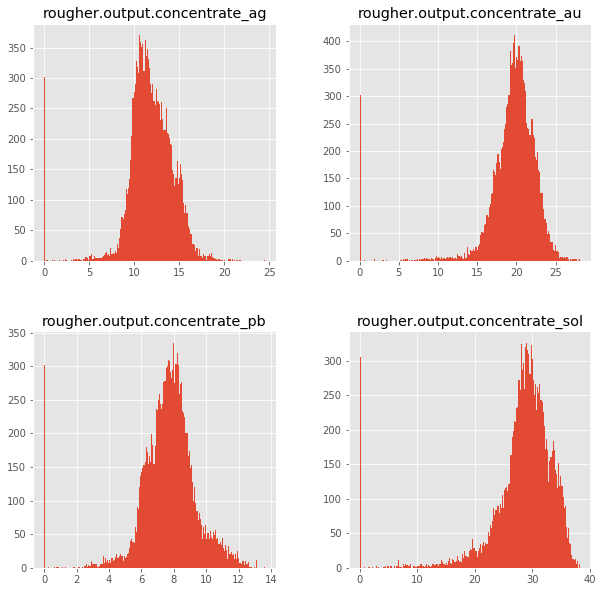

In [35]:
hist1 =  pd.DataFrame(train[['rougher.output.concentrate_ag','rougher.output.concentrate_pb', 'rougher.output.concentrate_au', 'rougher.output.concentrate_sol']]).hist(bins = 200, figsize = (10,10))

Первичная очистка:

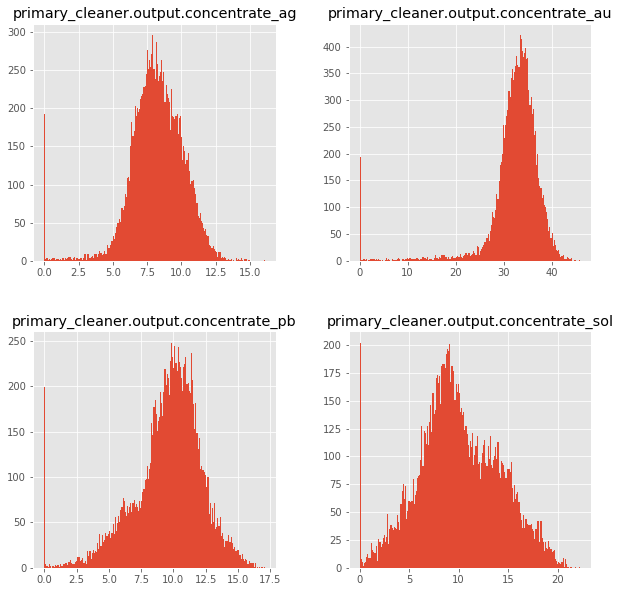

In [36]:
hist2 = pd.DataFrame(train[['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_sol']]).hist(bins = 200, figsize = (10,10))

Вторичная очистка:

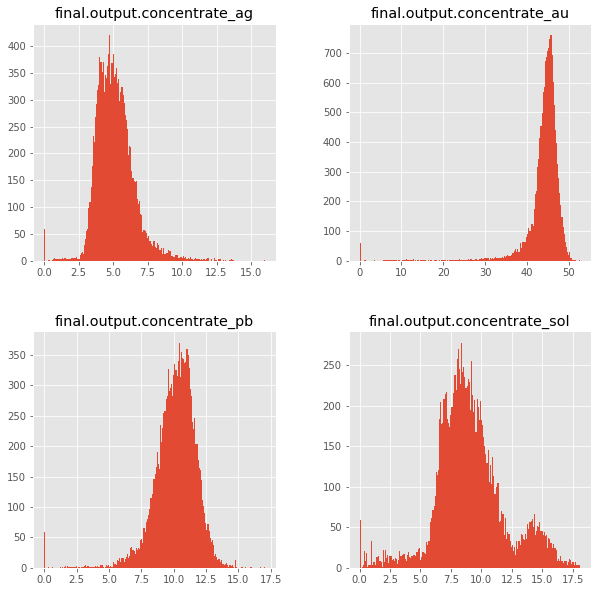

In [37]:
hist3 = pd.DataFrame(train[['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au','final.output.concentrate_sol']]).hist(bins = 200, figsize = (10,10))

Вывод: концентрация всех четырех металлов меняется в зависимости от стадии очистки, но в целом - везде нормальное распределение (присутствует смещение вправо и влево в зависимости от стадии).

## Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

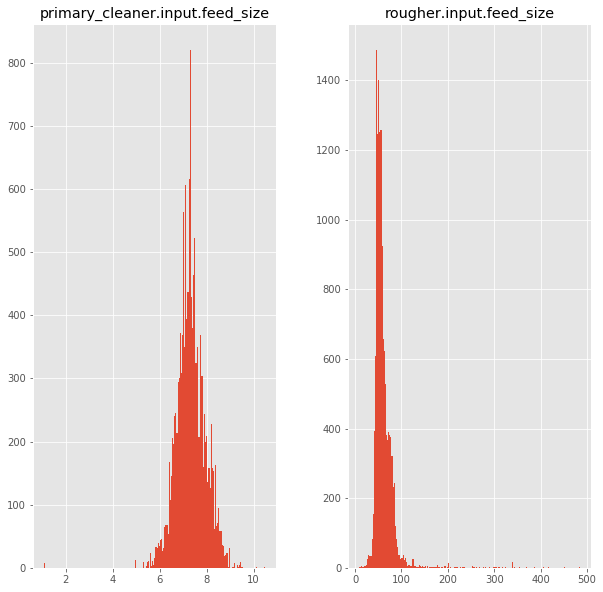

In [38]:
hist5 = pd.DataFrame(train[['rougher.input.feed_size', 'primary_cleaner.input.feed_size']]).hist(bins = 200, figsize = (10,10))


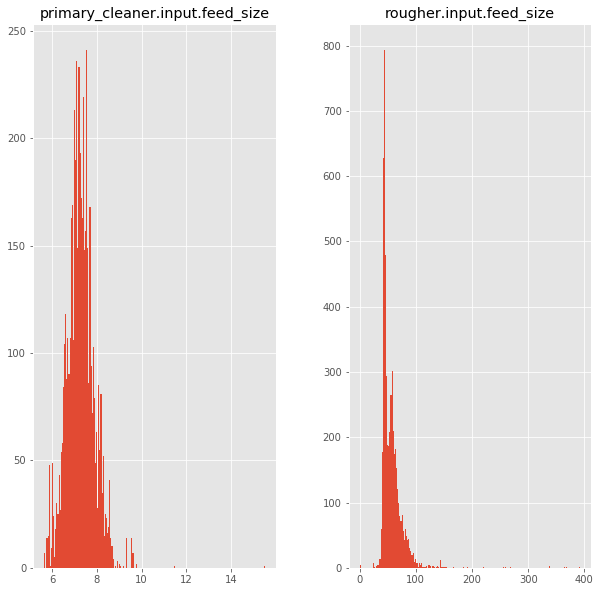

In [39]:
hist5 = pd.DataFrame(test[['rougher.input.feed_size', 'primary_cleaner.input.feed_size']]).hist(bins = 200, figsize = (10,10))


Вывод: Очистка незначительно влияет на размер гранул.

## Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [40]:
train['rougher'] = train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_pb'] + train['rougher.output.concentrate_au'] + train['rougher.output.concentrate_sol'] 

In [41]:
train['primary'] = train['primary_cleaner.output.concentrate_ag'] + train['primary_cleaner.output.concentrate_pb'] + train['primary_cleaner.output.concentrate_au'] + train['primary_cleaner.output.concentrate_sol']


In [42]:
train['final'] = train['final.output.concentrate_ag'] + train['final.output.concentrate_pb'] + train['final.output.concentrate_au'] + train['final.output.concentrate_sol']

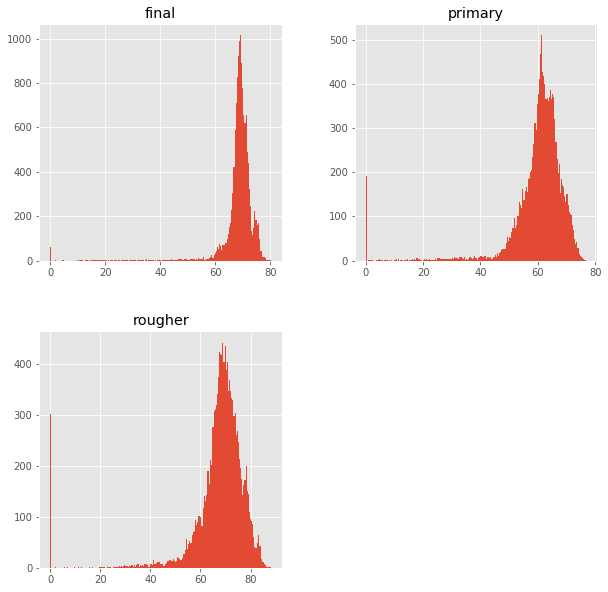

In [43]:
hist = pd.DataFrame(train[['rougher', 'primary', 'final']]).hist(bins = 200, figsize = (10,10))

Вывод:

1. Концентрация Ag и  Pb возрастает со степенью очистки сырья, а концентрация Ag уменьшается

2. Распределения флотации для train и test также как и распределения очень похожи, за исключением нескольких отклонений, которые не мешают расчетам

3. Сумммарная концентрация веществ учеличивается с очередной очисткой, что является хорошим признаком

4. Выбросы в распределении есть, но нет смысла их удалять, потому что эти выбросы значимы для задачи

Отредактируем выборки train и test: 

- в тестовую выборку добавим целевые признаки из выборки full - rougher.output.recovery','final.output.recovery

- из тренировочной выборки удалим значения, которых нет в тестовой выборке

In [44]:
#new_test = test.join(full[['rougher.output.recovery','final.output.recovery']])
new_test = test

In [45]:
new_test

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.80,14.99,8.08,1.01,"1,398.98",-500.23,"1,399.14",-499.92,"1,400.10",-500.70,"1,399.00",-499.49,13.13,5.64,489.79,62.71,42.02,12.08,16.92,6.15,16.87,6.15,"1,001.85",-350.30,"1,249.74",-399.11,"1,249.75",-399.40,"1,198.29",-399.49,999.47,-399.53,949.57,-398.18,24.94,-500.49,14.95,-500.01,20.02,-450.40,13.99,-449.83,12.02,-497.80,8.02,-501.29,7.95,-432.32,4.87,-500.04,26.71,-499.71,89.99,70.27
2016-09-01 01:59:59,215.39,14.99,8.08,0.99,"1,398.78",-500.06,"1,398.06",-499.78,"1,396.15",-499.24,"1,399.51",-500.42,13.04,5.53,490.10,61.96,41.19,11.92,17.00,6.00,17.00,6.00,998.69,-350.43,"1,248.40",-399.95,"1,249.51",-399.63,"1,200.51",-399.94,"1,000.00",-399.49,950.20,-405.79,24.92,-499.81,14.93,-500.76,19.99,-450.11,14.09,-450.06,12.06,-498.70,8.13,-499.63,7.96,-525.84,4.88,-500.16,25.02,-499.82,88.09,68.91
2016-09-01 02:59:59,215.26,12.88,7.79,1.00,"1,398.49",-500.87,"1,398.86",-499.76,"1,398.08",-502.15,"1,399.50",-499.72,13.14,5.43,489.62,66.90,42.55,12.09,16.99,5.85,16.98,5.85,998.52,-349.78,"1,247.44",-400.26,"1,248.21",-401.07,"1,199.77",-400.79,999.93,-399.24,950.32,-400.86,24.91,-500.30,15.00,-500.99,20.04,-450.26,14.08,-449.66,11.96,-498.77,8.10,-500.83,8.07,-500.80,4.91,-499.83,24.99,-500.62,88.41,68.14
2016-09-01 03:59:59,215.34,12.01,7.64,0.86,"1,399.62",-498.86,"1,397.44",-499.21,"1,400.13",-498.36,"1,401.07",-501.04,12.40,5.11,476.62,59.87,41.06,12.18,16.53,5.80,16.52,5.80,"1,000.28",-350.17,"1,251.32",-398.66,"1,250.49",-399.75,"1,199.40",-397.50,"1,001.93",-400.44,950.74,-399.80,24.89,-499.38,14.92,-499.86,20.03,-449.37,14.01,-449.53,12.03,-498.35,8.07,-499.47,7.90,-500.87,4.93,-499.96,24.95,-498.71,87.36,67.78
2016-09-01 04:59:59,199.10,10.68,7.53,0.81,"1,401.27",-500.81,"1,398.13",-499.50,"1,402.17",-500.81,"1,399.48",-499.37,11.33,4.77,488.25,63.32,41.27,11.29,13.61,5.74,13.65,5.74,996.54,-350.56,"1,304.66",-399.51,"1,306.46",-399.05,"1,248.70",-400.88,"1,058.84",-398.99,949.65,-399.28,24.89,-499.36,14.98,-500.19,19.96,-450.64,14.01,-450.02,12.03,-500

In [46]:
new_train = train[list(test.columns)]
#оствляем в тренировочном наборе только столбцы, 
#фигурирующие в валидационном наборе (и целевые переменные уже там есть)

In [47]:
new_train

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,127.09,10.13,7.25,0.99,"1,549.78",-498.91,"1,551.43",-516.40,"1,549.87",-498.67,"1,554.37",-493.43,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,999.71,-404.07,"1,603.01",-434.72,"1,602.38",-442.20,"1,598.94",-451.29,"1,404.47",-455.46,"1,416.35",-451.94,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84,87.11,70.54
2016-01-15 01:00:00,125.63,10.30,7.25,1.00,"1,576.17",-500.90,"1,575.95",-499.87,"1,575.99",-499.32,"1,574.48",-498.93,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,"1,000.29",-400.07,"1,600.75",-449.95,"1,600.48",-449.83,"1,600.53",-449.95,"1,399.23",-450.87,"1,399.72",-450.12,25.88,-499.99,23.89,-500.37,23.97,-500.09,22.09,-499.45,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79,86.84,69.27
2016-01-15 02:00:00,123.82,11.32,7.25,0.99,"1,601.56",-500.00,"1,600.39",-500.61,"1,602.00",-500.87,"1,599.54",-499.83,6.12,2.16,530.03,57.51,35.97,6.36,11.92,6.20,11.92,6.20,999.72,-400.07,"1,599.34",-450.01,"1,599.67",-449.95,"1,599.85",-449.95,"1,399.18",-449.94,"1,400.32",-450.53,26.01,-499.93,23.89,-499.95,23.91,-499.44,23.96,-499.90,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43,86.84,68.12
2016-01-15 03:00:00,122.27,11.32,7.25,1.00,"1,599.97",-500.95,"1,600.66",-499.68,"1,600.30",-500.73,"1,600.45",-500.05,6.04,2.04,542.59,57.79,36.86,6.12,11.63,6.20,11.69,6.20,999.81,-400.20,"1,600.06",-450.62,"1,600.01",-449.91,"1,597.73",-450.13,"1,400.94",-450.03,"1,400.23",-449.79,25.94,-499.18,23.96,-499.85,23.97,-500.01,23.95,-499.94,14.04,-500.86,12.00,-501.19,9.97,-499.20,7.98,-500.26,14.01,-600.00,87.23,68.35
2016-01-15 04:00:00,117.99,11.91,7.25,1.01,"1,601.34",-498.98,"1,601.44",-500.32,"1,599.58",-500.89,"1,602.65",-500.59,6.06,1.79,540.53,56.05,34.35,5.66,10.96,6.20,10.96,6.19,999.68,-399.75,"1,600.21",-449.60,"1,600.36",-450.03,"1,599.76",-449.91,"1,401.56",-448.88,"1,401.16",-450.41,26.02,-500.28,23.96,-500.59,23.99,-500.08,23.9

In [49]:
new_train

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,127.09,10.13,7.25,0.99,"1,549.78",-498.91,"1,551.43",-516.40,"1,549.87",-498.67,"1,554.37",-493.43,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,999.71,-404.07,"1,603.01",-434.72,"1,602.38",-442.20,"1,598.94",-451.29,"1,404.47",-455.46,"1,416.35",-451.94,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84,87.11,70.54
2016-01-15 01:00:00,125.63,10.30,7.25,1.00,"1,576.17",-500.90,"1,575.95",-499.87,"1,575.99",-499.32,"1,574.48",-498.93,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,"1,000.29",-400.07,"1,600.75",-449.95,"1,600.48",-449.83,"1,600.53",-449.95,"1,399.23",-450.87,"1,399.72",-450.12,25.88,-499.99,23.89,-500.37,23.97,-500.09,22.09,-499.45,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79,86.84,69.27
2016-01-15 02:00:00,123.82,11.32,7.25,0.99,"1,601.56",-500.00,"1,600.39",-500.61,"1,602.00",-500.87,"1,599.54",-499.83,6.12,2.16,530.03,57.51,35.97,6.36,11.92,6.20,11.92,6.20,999.72,-400.07,"1,599.34",-450.01,"1,599.67",-449.95,"1,599.85",-449.95,"1,399.18",-449.94,"1,400.32",-450.53,26.01,-499.93,23.89,-499.95,23.91,-499.44,23.96,-499.90,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43,86.84,68.12
2016-01-15 03:00:00,122.27,11.32,7.25,1.00,"1,599.97",-500.95,"1,600.66",-499.68,"1,600.30",-500.73,"1,600.45",-500.05,6.04,2.04,542.59,57.79,36.86,6.12,11.63,6.20,11.69,6.20,999.81,-400.20,"1,600.06",-450.62,"1,600.01",-449.91,"1,597.73",-450.13,"1,400.94",-450.03,"1,400.23",-449.79,25.94,-499.18,23.96,-499.85,23.97,-500.01,23.95,-499.94,14.04,-500.86,12.00,-501.19,9.97,-499.20,7.98,-500.26,14.01,-600.00,87.23,68.35
2016-01-15 04:00:00,117.99,11.91,7.25,1.01,"1,601.34",-498.98,"1,601.44",-500.32,"1,599.58",-500.89,"1,602.65",-500.59,6.06,1.79,540.53,56.05,34.35,5.66,10.96,6.20,10.96,6.19,999.68,-399.75,"1,600.21",-449.60,"1,600.36",-450.03,"1,599.76",-449.91,"1,401.56",-448.88,"1,401.16",-450.41,26.02,-500.28,23.96,-500.59,23.99,-500.08,23.9

Построим модели отдельно для признаков rougher.output.recovery и final.output.recovery.

In [50]:
features_train = new_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target1_train = new_train['rougher.output.recovery']
target2_train = new_train['final.output.recovery']

test_features = new_test.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target1_test = new_test['rougher.output.recovery']
target2_test = new_test['final.output.recovery']

## Итоговый sMAPE

In [51]:
def smape(y_true, y_predicted):
    res = 100 / len(y_true) * np.sum(2 * np.abs(y_true - y_predicted) / (np.abs(y_true) + np.abs(y_predicted))) 
    
    return res   

def smape_final(rougher_true, rougher_predicted, final_true, final_predicted):
    smape_rougher = smape(rougher_true, rougher_predicted)
    smape_final = smape(final_true, final_predicted)
    
    res = 0.25 * smape_rougher + 0.75 * smape_final
    
    return res

my_scorer = make_scorer(smape, greater_is_better = False) #будет одинаковым для всех моделей

#оценка модели по кросс-валидации
def calc_cross_score(model, features, true_target):
    res = cross_val_score(model, features, true_target, scoring=my_scorer, cv=5)
    
    return res

## Линейная модель

In [52]:
model_regression = LinearRegression()

model_regression.fit(features_train, target1_train)
predictions_test_1 = model_regression.predict(test_features)

cross_score_train_1 = calc_cross_score(model_regression, features_train, target1_train)
print('Оценка кросс-валидации линейной модели по 1 таргету:', cross_score_train_1.mean())

model_regression.fit(features_train, target2_train)
predictions_test_2 = model_regression.predict(test_features)

cross_score_train_2 = calc_cross_score(model_regression, features_train, target2_train)
print('Оценка кросс-валидации линейной модели по 2 таргету:', cross_score_train_2.mean())

final_score = smape_final(target1_test, predictions_test_1, target2_test, predictions_test_2)
print('Итоговое SMAPE линейной модели на валидационной выборке = ', final_score)

Оценка кросс-валидации линейной модели по 1 таргету: -12.802483458481959
Оценка кросс-валидации линейной модели по 2 таргету: -12.24530032030224
Итоговое SMAPE линейной модели на валидационной выборке =  9.972775555351223


## Дерево решений

Подберем гиперпараметры лучшей модели:

In [53]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV


gs = GridSearchCV(DecisionTreeRegressor(random_state=42),
                  param_grid={'min_samples_split': range(2, 403, 10)},
                  scoring=my_scorer)
gs.fit(features_train, target1_train)
results = gs.cv_results_
print(results)

{'mean_fit_time': array([0.94689139, 0.86746184, 0.89191039, 0.83111024, 0.84537196,
       0.79718415, 0.80863738, 0.74821599, 0.76585015, 0.72467597,
       0.71378859, 0.70272366, 0.6944317 , 0.68069752, 0.70000188,
       0.70046242, 0.69522007, 0.65229193, 0.64893333, 0.65814392,
       0.63020762, 0.61907498, 0.62702107, 0.64671914, 0.61146347,
       0.59823918, 0.59452462, 0.62634683, 0.58548752, 0.57880036,
       0.59171478, 0.5668536 , 0.57912993, 0.56400911, 0.56597527,
       0.58963521, 0.57537421, 0.56981738, 0.56590613, 0.55350828,
       0.57490794]), 'std_fit_time': array([0.09464202, 0.10702239, 0.01714862, 0.11041409, 0.12466024,
       0.07293143, 0.09821281, 0.07985927, 0.08707907, 0.08907629,
       0.07862464, 0.07249098, 0.07835958, 0.0760638 , 0.0853115 ,
       0.09239047, 0.02899168, 0.0677448 , 0.07160028, 0.05169617,
       0.07620126, 0.07815575, 0.0848852 , 0.12805561, 0.09369303,
       0.07748221, 0.07432902, 0.12376254, 0.08656621, 0.08286503,
       

In [54]:
gs.fit(features_train, target2_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=42,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_split': range(2, 403, 10)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(smape, greater_is_better=False), v

In [55]:
#проверим модель с выбранными гиперпараметрами на валидационной выборке и вычислим кросс-валидацию

model_tree_regression = DecisionTreeRegressor(random_state=42, max_depth=48)

model_tree_regression.fit(features_train, target1_train)
predictions_test_1 = model_tree_regression.predict(test_features)

cross_score_train_1 = calc_cross_score(model_tree_regression, features_train, target1_train)
print('Оценка кросс-валидации линейной модели по 1 таргету:', cross_score_train_1.mean())

model_tree_regression.fit(features_train, target2_train)
predictions_test_2 = model_tree_regression.predict(test_features)

cross_score_train_2 = calc_cross_score(model_tree_regression, features_train, target2_train)
print('Оценка кросс-валидации дерева решений по 2 таргету:', cross_score_train_2.mean())

final_score = smape_final(target1_test, predictions_test_1, target2_test, predictions_test_2)
print('Итоговое SMAPE дерева решений на валидационной выборке = ', final_score)

Оценка кросс-валидации линейной модели по 1 таргету: -18.44581942023483
Оценка кросс-валидации дерева решений по 2 таргету: -23.780366440029503
Итоговое SMAPE дерева решений на валидационной выборке =  15.67729039102047


## Случайный лес

In [56]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

model_forest_regression= RandomForestRegressor(random_state=12345)

parametrs = { 'n_estimators': range (100, 500, 20),
              'max_depth': range (1,11),
              'min_samples_leaf': range (1,5)}
my_scorer = make_scorer(smape, greater_is_better=False)
grid = GridSearchCV(model_forest_regression, parametrs, cv=3, scoring=my_scorer)
grid.fit(features_train, target1_train)
grid.best_params_

grid.fit(features_train, target2_train)
grid.best_params_

In [ ]:
model_forest_regression = RandomForestRegressor(random_state=42, n_estimators = 200, max_depth = 7)

model_forest_regression.fit(features_train, target1_train)
predictions_test_1 = model_forest_regression.predict(test_features)

cross_score_train_1 = calc_cross_score(model_forest_regression, features_train, target1_train)
print('Оценка кросс-валидации случайного леса по 1 таргету:', cross_score_train_1.mean())

model_forest_regression.fit(features_train, target2_train)
predictions_test_2 = model_forest_regression.predict(test_features)

cross_score_train_2 = calc_cross_score(model_forest_regression, features_train, target2_train)
print('Оценка кросс-валидации случайного леса по 2 таргету:', cross_score_train_2.mean())

final_score = smape_final(target1_test, predictions_test_1, target2_test, predictions_test_2)
print('Итоговое SMAPE случайного леса на валидационной выборке = ', final_score)

Лучшей моделью является линейная модель. 

Проверим качество лучшей модели на тестовой выборке:

In [ ]:
model_regression_1 = LinearRegression()
model_regression_1.fit(features_train, target1_train)

model_regression_2 = LinearRegression()
model_regression_2.fit(features_train, target2_train)


predictions_test_1 = model_regression_1.predict(test_features)
predictions_test_2 = model_regression_2.predict(test_features)

print('Предсказание линейной модели на тестовой выборке по 1 таргету:', predictions_test_1)
print('Предсказание линейной модели на тестовой выборке по 2 таргету:', predictions_test_2)

final_linear_score = smape_final(target1_test, predictions_test_1, target2_test, predictions_test_2)
print('Итоговое SMAPE линейной модели на тестовой выборке = ', final_linear_score)

## 4. Результаты исследования

1. Мы подготовили прототип модели машинного обучения для «Цифры». 

2. Полученная модель  предсказывает коэффициент восстановления золота из золотосодержащей руды.

3. Наиболее эффективной моделью машинного обучения является линейная модель, что доказано кросс-валидацией;

4. Линейная модель проверена на тестовой выборке, ее итоговое SMAPE не упало, а даже возросло, чт доказывает эффективность модели.

 